# Vision

> This is functionality for getting visual information into python so our agent can process it.

In [ ]:
#| default_exp vision
#| export
from algorithmic_gamer.types import *
from algorithmic_gamer.fuzzer import *

from typing import Union, Tuple, Any
from dataclasses import dataclass
from datetime import datetime

import win32gui
import win32ui
import win32con
import win32api

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
def f_get_region(location: Union[Window, Region]) -> Tuple[int, Region, int, int]:
    """
    Get the relevant handle and the region to be captured.
    
    Parameters:
    location (Window or Region): The window or region to capture.
    
    Returns:
    Tuple[int, Region, int, int]: A tuple containing the handle to the window or desktop,
        the region to be captured, and the width and height of the region.
    """
    if isinstance(location, Region):
        # Get the handle to the desktop window.
        hwin = win32gui.GetDesktopWindow()
        
        # Calculate the width and height of the region.
        width = location.right - location.left + 1
        height = location.bottom - location.top + 1
        
        return hwin, location, int(width), int(height)
    elif isinstance(location, Window):
        
        # Get the handle to the application window.
        hwin = win32gui.FindWindow(None, location.app_name)
        
        if location.sub_region is not None: # a subregion is defined
            width = location.sub_region.right - location.sub_region.left + 1
            height = location.sub_region.bottom - location.sub_region.top + 1
            
            return hwin, location.sub_region, int(width), int(height)
        else:# no subregion, capture the entire window
            
            # Get the dimensions of the client area.
            left, top, right, bottom = win32gui.GetClientRect(hwin)
            # Convert the client area coordinates to screen coordinates.
            left, top = win32gui.ClientToScreen(hwin, (left, top))
            right, bottom = win32gui.ClientToScreen(hwin, (right, bottom))

            # Get the width and height of the client area.
            width = right - left
            height = bottom - top
            
            ##TODO win32gui.FindWindow appears to return include margin shadows in the size
            return hwin, Region(left=0+7, top=0, right=right, bottom=bottom), int(width), int(height)

In [ ]:
#| export
def f_view(location: Union[Window, Region], time: bool = False) -> np.ndarray:
    """
    Capture a screenshot of the specified window or region on the desktop.
    
    Parameters:
    location (Window or Region): The window or region to capture.
    
    Returns:
    np.ndarray: The screenshot as a 3-channel image in RGB format.
    """
    hwin, region, width, height = f_get_region(location)

    # Create a device context (DC) for the window or desktop.
    hwindc = win32gui.GetWindowDC(hwin)
    srcdc = win32ui.CreateDCFromHandle(hwindc)
    
    # Create a compatible DC.
    memdc = srcdc.CreateCompatibleDC()
    
    # Create a bitmap object and select it into the memory DC.
    bmp = win32ui.CreateBitmap()
    bmp.CreateCompatibleBitmap(srcdc, width, height)
    memdc.SelectObject(bmp)
    
    # Perform a bit block transfer (BitBlt) from the window or desktop DC to the memory DC.
    memdc.BitBlt((0, 0), (width, height), srcdc, (int(region.left), int(region.top)), win32con.SRCCOPY)
    write_time = datetime.utcnow().timestamp()
    
    # Retrieve the bitmap bits as a signed integer array.
    signed_ints_array = bmp.GetBitmapBits(True)
    
    # Convert the array to an unsigned 8-bit integer NumPy array.
    img = np.frombuffer(signed_ints_array, dtype='uint8')
    # BGRA2RGB without cv2
    img = img.reshape(height, width, 4)[:, :, [2, 1, 0]]
        
    # Delete the DCs and the bitmap object.
    srcdc.DeleteDC()
    memdc.DeleteDC()
    win32gui.ReleaseDC(hwin, hwindc)
    win32gui.DeleteObject(bmp.GetHandle())
    
    if time:return img, write_time
    
    else: return img

screencapture of desktop at Region(left=480.0, top=270.0, right=1440.0, bottom=810.0)


<matplotlib.image.AxesImage>

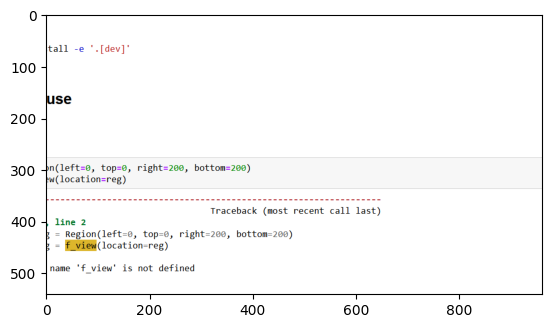

In [ ]:
#| ignore
w = int(1920/2)
h = int(1080/2)
reg = Region(left=w-(w/2), top=h-(h/2), right=w+(w/2), bottom=h+(h/2))
img = f_view(location=reg)
print(f'screencapture of desktop at {reg}')
plt.imshow(img)


<matplotlib.image.AxesImage>

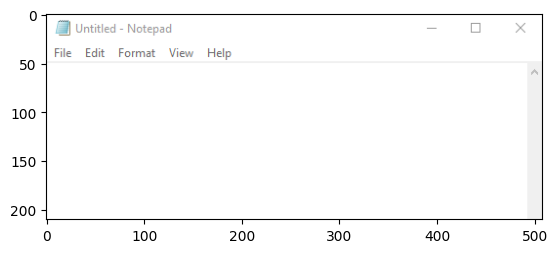

In [ ]:
#| ignore
img = f_view(location=Window(app_name=fuzzy_app('untilted - notepad')))
plt.imshow(img)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()